# Proyecto Simulación de sistemas: House prices

* Luis Ernesto Monsalve Arango
ernesto.monsalve@udea.edu.co
* Johnatan Andrés Gómez Monsalve
johnatana.gomez@udea.edu.co

### Importando librerías y cargando datos

In [1]:
import time
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit, StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer 
from scipy.spatial.distance import cdist 
from scipy.stats import skew, norm

In [2]:
# Para evitar que la siguiente linea falle
! rm -r house-prices/

In [3]:
# Carga los datos
! git clone https://github.com/Luisem11/house-prices

Cloning into 'house-prices'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 8 (delta 1), reused 8 (delta 1), pack-reused 0
Unpacking objects: 100% (8/8), done.


In [4]:
df = pd.read_csv('/content/house-prices/data/train.csv',index_col='Id')

### Exploración de los datos

In [5]:
def getMissingValues(df):
  all_data_na = (df.isnull().sum() / len(df)) * 100
  all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:]
  missing_data = pd.DataFrame({'% Faltantes' :all_data_na})
  return missing_data

In [6]:
df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

#### Distribucipon de variable de salida

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


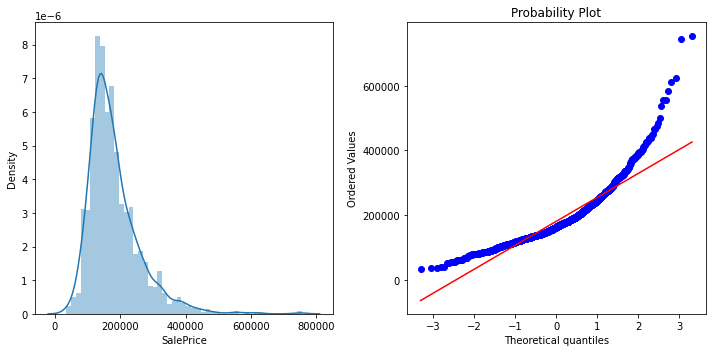

In [7]:
from scipy import stats
y= df['SalePrice']
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
plt.subplot(1, 2, 1)
sns.distplot(y)
plt.subplot(1, 2, 2)
stats.probplot(y,plot=plt)
plt.tight_layout()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


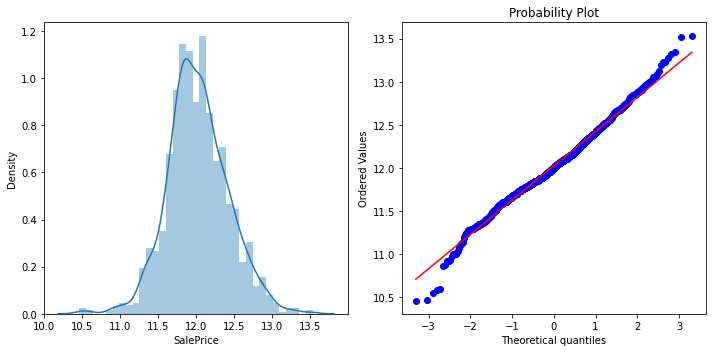

In [8]:
y= np.log1p(df['SalePrice'])
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
plt.subplot(1, 2, 1)
sns.distplot(y)
plt.subplot(1, 2, 2)
stats.probplot(y,plot=plt)
plt.tight_layout()

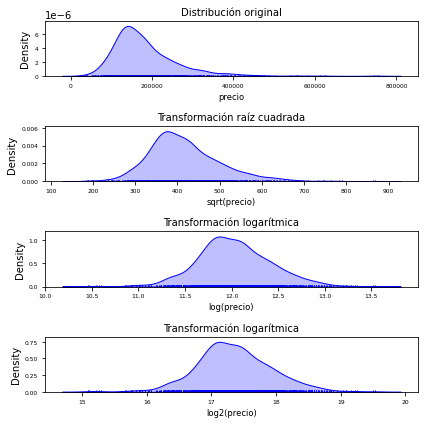

In [9]:
import warnings
warnings.filterwarnings("ignore")
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(6, 6))
sns.distplot(
    df['SalePrice'],
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[0]
)
axes[0].set_title("Distribución original", fontsize = 'medium')
axes[0].set_xlabel('precio', fontsize='small') 
axes[0].tick_params(labelsize = 6)

sns.distplot(
    np.sqrt(df['SalePrice']),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[1]
)
axes[1].set_title("Transformación raíz cuadrada", fontsize = 'medium')
axes[1].set_xlabel('sqrt(precio)', fontsize='small') 
axes[1].tick_params(labelsize = 6)

sns.distplot(
    np.log(df['SalePrice']),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[2]
)
axes[2].set_title("Transformación logarítmica", fontsize = 'medium')
axes[2].set_xlabel('log(precio)', fontsize='small') 
axes[2].tick_params(labelsize = 6)

sns.distplot(
    np.log2(df['SalePrice']),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[3]
)
axes[3].set_title("Transformación logarítmica", fontsize = 'medium')
axes[3].set_xlabel('log2(precio)', fontsize='small') 
axes[3].tick_params(labelsize = 6)

fig.tight_layout()

#### Matriz de correlación

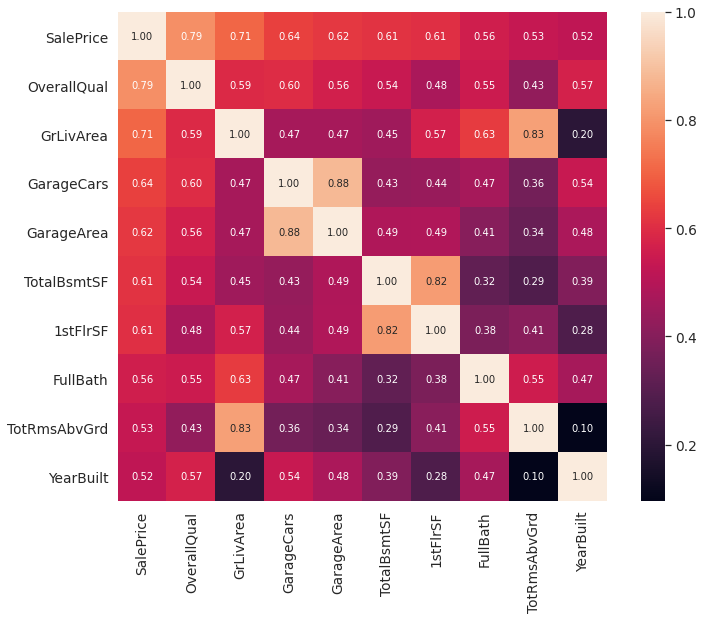

In [10]:
k = 10
corrmat = df.corr()
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
plt.subplots(figsize=(12,9))
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 10},
                 yticklabels=cols.values,
                 xticklabels=cols.values)
plt.show()

#### Valores faltantes

In [11]:
getMissingValues(df)

,% Faltantes
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
FireplaceQu,47.260274
LotFrontage,17.739726
GarageYrBlt,5.547945
GarageType,5.547945
GarageFinish,5.547945
GarageQual,5.547945


### Preprocesamiento de datos

Se ópta por trabajar con la versión normalizada de la clase de salida y por borrar cuatro columnas porque sus porcentajes faltantes de datos son muy altos

In [12]:
df['SalePrice'] = np.log1p(df['SalePrice'])

In [13]:
# Deleting features from both dataset
train_labels = df['SalePrice'].reset_index(drop=True)

df = df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], 1)

In [14]:
categorical_features = df.select_dtypes(include=['object']).columns
categorical_features

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [15]:
# Numerical features
numerical_features = df.select_dtypes(exclude = ["object"]).columns
numerical_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

Llenando valores faltantes

In [16]:
for col in categorical_features:
  df[col] = df[col].fillna('None')
df['FireplaceQu'] = df['FireplaceQu'].fillna('None')
df['GarageQual'] = df['GarageQual'].fillna('None')
df['GarageFinish'] = df['GarageFinish'].fillna('None')
df['GarageCond'] = df['GarageCond'].fillna('None')
df['GarageType'] = df['GarageType'].fillna('None')
df['BsmtExposure'] = df['BsmtExposure'].fillna('None')
df['BsmtQual'] = df['BsmtQual'].fillna('None')
df['BsmtCond'] = df['BsmtCond'].fillna('None')
df['BsmtFinType2'] = df['BsmtFinType2'].fillna('None')
df['BsmtFinType1'] = df['BsmtFinType1'].fillna('None')
df['MasVnrType'] = df['MasVnrType'].fillna('None')
df['BsmtFinType2'] = df['BsmtFinType2'].fillna('None')
df['LotFrontage'] = df['LotFrontage'].fillna(np.sqrt(df['LotArea']))
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['YearBuilt'])
df['GarageCars'] = df['GarageCars'].fillna(2)
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)
df['MSZoning'] = df['MSZoning'].fillna(value='RL')
df['Utilities'] = df['Utilities'].fillna(value='AllPub')
df['BsmtHalfBath'] = df['BsmtHalfBath'].fillna(0)
df['BsmtFullBath'] = df['BsmtFullBath'].fillna(0)
df['Functional'] = df['Functional'].fillna(df['Functional'].mode()[0])
df['BsmtFinSF1'] = df['BsmtFinSF1'].fillna(0)
df[['TotalBsmtSF','BsmtUnfSF']] = df[['TotalBsmtSF','BsmtUnfSF']].fillna(0)
df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
df[['Exterior1st','Exterior2nd']] = df[['Exterior1st','Exterior2nd']].fillna('MetalSd')
df['Electrical'] = df['Electrical'].fillna(value='SBrkr')
df['KitchenQual'] = df['KitchenQual'].fillna(value='TA')

In [17]:
getMissingValues(df)

,% Faltantes


In [18]:
enc = LabelEncoder()
df[categorical_features] = df[categorical_features].apply(LabelEncoder().fit_transform)


### Muestreo de datos

In [29]:
def splitData(df):
  X = df.iloc[:, :-1]
  y = df.iloc[:,-1:]
  Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.2)
  return Xtrain, Xtest, Ytrain, Ytest, X, y

In [31]:
Xtrain, Xtest, Ytrain, Ytest, x, y = splitData(df)
print(df.shape, Xtrain.shape, Xtest.shape, Ytrain.shape)

(1460, 76) (1168, 75) (292, 75) (1168, 1)


### Validación




In [26]:
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    

def validate(ytest, ypred, show_r = False):
  MAE = mean_absolute_error(ytest, ypred)
  MAPE_ = MAPE(ytest, ypred)
  MSE = mean_squared_error(ytest, ypred)
  RMSE = np.sqrt(MSE)
  r2 = r2_score(ypred,ytest)
  if (show_r):
    print("MAE: ", MAE)
    print("MAPE: ", MAPE_)
    print("Error cuadrático medio: ", MSE)
    print("Raiz ECM: ", RMSE)
    print("R2: ", r2)
  else:
    return MAE, MAPE_, MSE, RMSE

### Modelos

#### Regresion múltiple 

In [32]:
reg=LinearRegression()   
reg.fit(Xtrain,Ytrain)
reg_pred = reg.predict(Xtest)

In [23]:
validate(Ytest, reg_pred , show_r= True )

MAE:  0.09920165929169998
MAPE:  0.8289515256896051
Error cuadrático medio:  0.041889593410668155
Raiz ECM:  0.204669473568161
R2:  0.7263082101896692


#### KNN


In [28]:
from sklearn.model_selection import GridSearchCV

In [29]:
# importing KNN regression
from sklearn.neighbors import KNeighborsRegressor
parameters = {
            'n_neighbors' : [1,2,3,4,5,6,7,8,9,10],
            'algorithm' : ['ball_tree', 'brute']
             }
grid_search_cv = GridSearchCV(KNeighborsRegressor(), parameters)
grid_search_cv.fit(Xtrain, Ytrain)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ['ball_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [30]:
grid_search_cv.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 5}

In [58]:
knn = KNeighborsRegressor(n_neighbors = 7, algorithm='ball_tree')
# fitting the model with the training dataset
knn.fit(Xtrain, Ytrain)
# predicting the values
predicted_value = knn.predict(Xtest)

print(knn.score(Xtrain, Ytrain))
validate(Ytest, predicted_value , show_r= True )


0.76447799599814
MAE:  0.16193962778222062
MAPE:  1.3452729916690904
Error cuadrático medio:  0.0474416292576155
Raiz ECM:  0.21781099434513285
R2:  0.4982104104379763



#### Random Forest

In [32]:
parameters = {
            'n_estimators' : [20, 50, 100],
            'max_depth' : [15,18,20]
             }
grid_search_cv = GridSearchCV(RandomForestRegressor(), parameters)
grid_search_cv.fit(Xtrain, Ytrain.values.ravel())

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [36]:
grid_search_cv.best_params_

{'max_depth': 15, 'n_estimators': 100}

In [37]:
rf = RandomForestRegressor(n_estimators=100,
                          max_depth=15)
rf.fit(Xtrain, Ytrain.values.ravel())
predicted_value = rf.predict(Xtest)

validate(Ytest, predicted_value, show_r=True)

MAE:  0.083120107679978
MAPE:  3.5075187215761
Error cuadrático medio:  0.013698828388081001
Raiz ECM:  0.11704199412211413
R2:  0.8947023643281636


#### GradientBosting

In [51]:

rlf = GradientBoostingRegressor()
rlf.fit(Xtrain,Ytrain.values.ravel())
predicted_value = rlf.predict(Xtest)
validate(Ytest, predicted_value, show_r=True)


MAE:  0.07572523487675782
MAPE:  3.559019340353755
Error cuadrático medio:  0.010384261233308125
Raiz ECM:  0.10190319540283378
R2:  0.9254080308272843


#### Regresion por Vectores de Soporte con kernel RBF.

In [38]:

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

In [39]:
from sklearn.svm import SVR

In [40]:
parameters = {
            'epsilon': [0.004, 0.008, 0.0005, 0.0008]
             }
grid_search_cv = GridSearchCV(SVR(), parameters)
grid_search_cv.fit(Xtrain, Ytrain.values.ravel())

GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'epsilon': [0.004, 0.008, 0.0005, 0.0008]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [41]:
grid_search_cv.best_params_

{'epsilon': 0.008}

In [43]:
# Support Vector Regressor
svr = make_pipeline(StandardScaler(), SVR(kernel='rbf', epsilon= 0.008))

# fitting the model with the training dataset
svr.fit(Xtrain, Ytrain.values.ravel())
# predicting the values
predicted_value = svr.predict(Xtest)

validate(Ytest, predicted_value, show_r=True)

MAE:  0.0954946397556736
MAPE:  3.4630303730530976
Error cuadrático medio:  0.02532644790504285
Raiz ECM:  0.15914285376680554
R2:  0.7929192192191681


Conclusión

### Extracción de Caracteristicas por PCA


In [85]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

In [86]:
def extract_features(n):
    ext = PCA(n_components=n)
    return ext

scaler = RobustScaler()
X_scaled = scaler.fit(Xtrain).transform(Xtrain)

pca =  extract_features(0.95)

X_scaled=pca.fit_transform(X_scaled)
y_log = np.log(Ytrain)
test_X_scaled = pca.transform(Xtest)
y_log_test = np.log(Ytest)

In [87]:
reg = LinearRegression()
reg.fit(X_scaled, y_log)
predicted_value = reg.predict(test_X_scaled)
validate(Ytest, predicted_value, show_r=True)

MAE:  9.537540807492414
MAPE:  79.29651415299327
Error cuadrático medio:  91.13289761226768
Raiz ECM:  9.54635520040333
R2:  -125874196.95882525


##### Random Forest

In [89]:
rf = RandomForestRegressor(n_estimators=1100,
                          max_depth=15)

rf.fit(X_scaled, y_log)
predicted_value = rf.predict(test_X_scaled)
validate(Ytest, predicted_value, show_r=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


MAE:  9.518170426703584
MAPE:  79.13523217790302
Error cuadrático medio:  90.76288329657288
Raiz ECM:  9.526955615335513
R2:  -622516.9536808992


##### Gradient Boosting

In [90]:
rlf = GradientBoostingRegressor()
rlf.fit(Xtrain,Ytrain.values.ravel())
rlf.fit(X_scaled, y_log)
predicted_value = rlf.predict(test_X_scaled)
validate(Ytest, predicted_value, show_r=True)

MAE:  9.52690939133198
MAPE:  79.20799535537158
Error cuadrático medio:  90.92928910216959
Raiz ECM:  9.535685035809939
R2:  -1718787.6934697302


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
